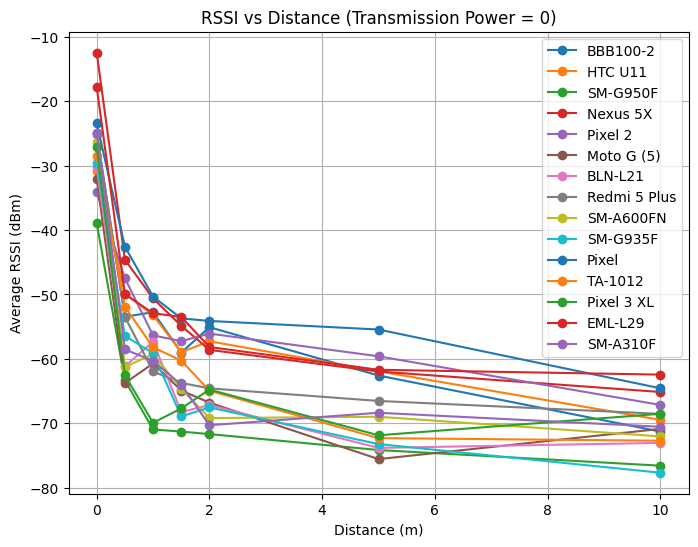

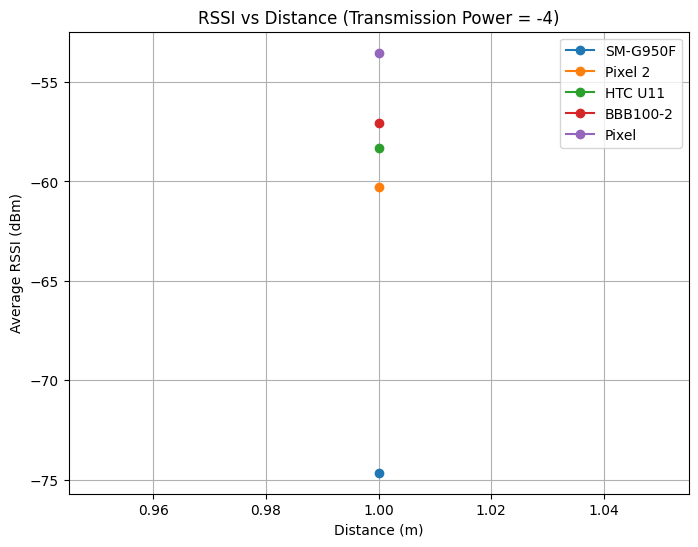

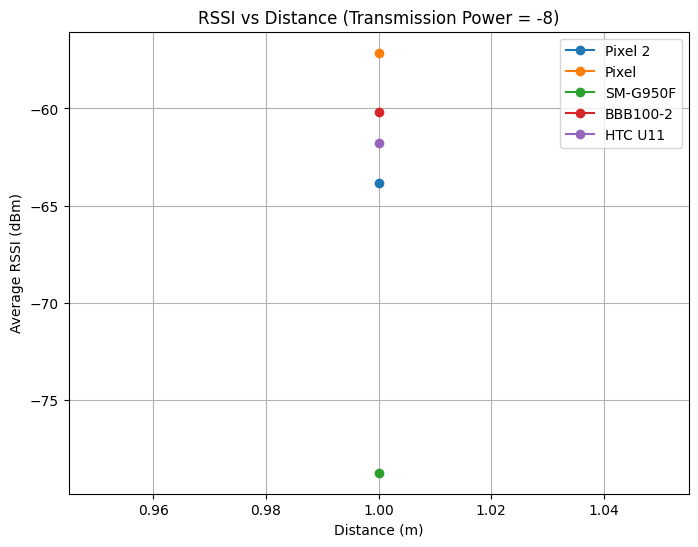

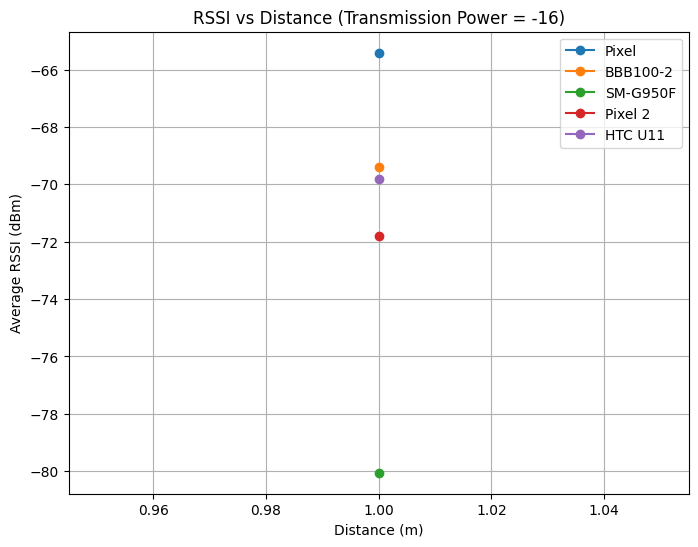

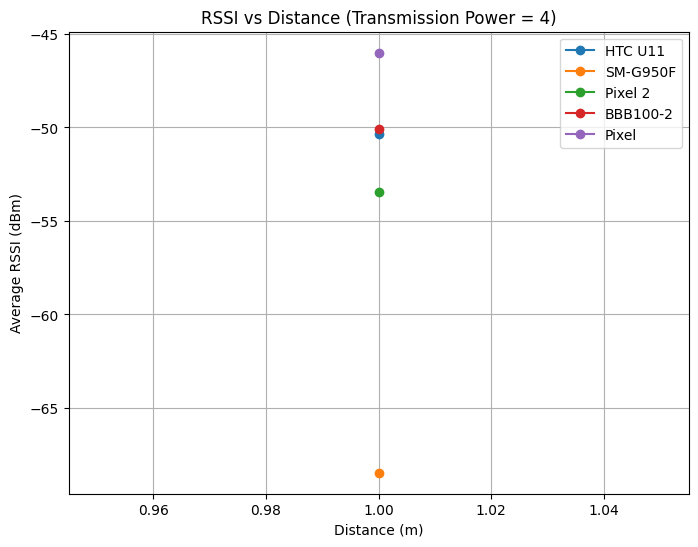

In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 读取所有 JSON 文件 ===
data_list = []
for file in glob.glob("recordings/*.json"):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)

        transmission_power = data["beaconInfo"]["transmissionPower"]
        device_model = data["deviceInfo"]["model"]
        distance = data["distance"]
        rssis = data["rssis"]

        # 每个 RSSI 都展开成单独一行
        for rssi in rssis:
            data_list.append({
                "transmissionPower": transmission_power,
                "deviceModel": device_model,
                "distance": distance,
                "rssi": rssi
            })

# === 2. 转换成 DataFrame ===
df = pd.DataFrame(data_list)

# === 3. 画图：同 transmissionPower 下，不同设备型号 RSSI 随距离变化 ===
for tp in df["transmissionPower"].unique():
    subset = df[df["transmissionPower"] == tp]

    plt.figure(figsize=(8,6))
    for model in subset["deviceModel"].unique():
        model_data = subset[subset["deviceModel"] == model]
        
        # 按距离分组取平均 RSSI（避免同距离太多点）
        grouped = model_data.groupby("distance")["rssi"].mean()
        plt.plot(grouped.index, grouped.values, marker="o", label=model)
    
    plt.title(f"RSSI vs Distance (Transmission Power = {tp})")
    plt.xlabel("Distance (m)")
    plt.ylabel("Average RSSI (dBm)")
    plt.legend()
    plt.grid(True)
    plt.show()


已解析到的 transmissionPower（dBm）: [-16, -8, -4, 0, 4]

每个功率 × 型号 的样本数：
device_model  BBB100-2  BLN-L21  EML-L29  HTC U11  Moto G (5)  Nexus 5X  \
tp_dbm                                                                    
-16                336        0        0      902           0         0   
-8                 384        0        0     1037           0         0   
-4                 346        0        0     1069           0         0   
 0                2857     1846     1898     8417         880      1379   
 4                 424        0        0     1132           0         0   

device_model  Pixel  Pixel 2  Pixel 3 XL  Redmi 5 Plus  SM-A310F  SM-A600FN  \
tp_dbm                                                                        
-16             509      897           0             0         0          0   
-8              614     1007           0             0         0          0   
-4              629     1018           0             0         0          0   
 0          

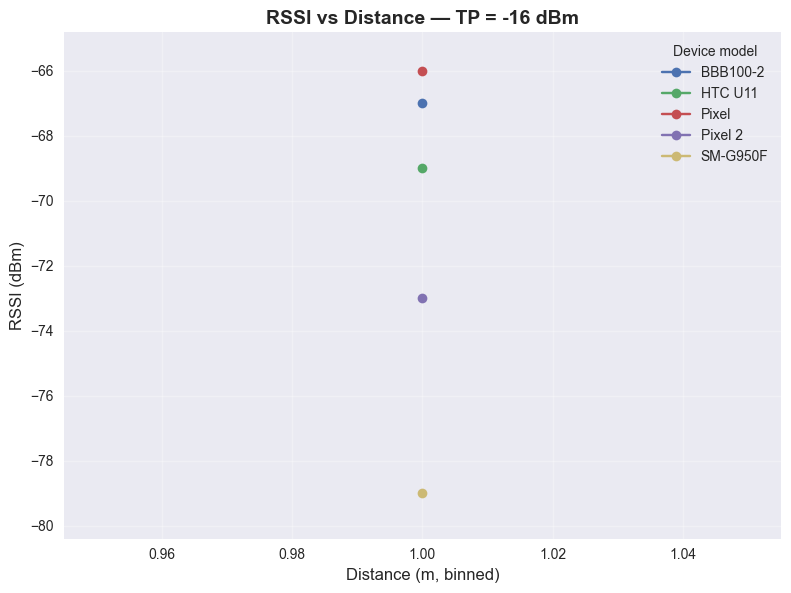

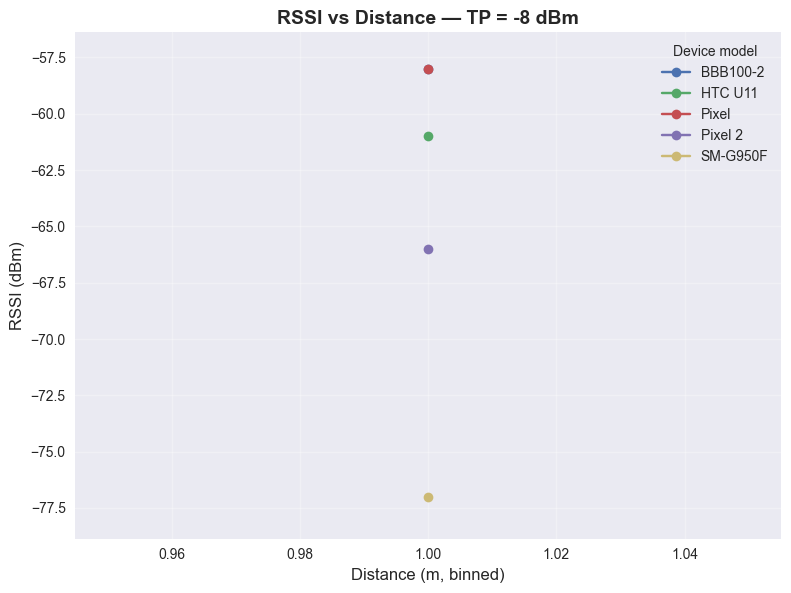

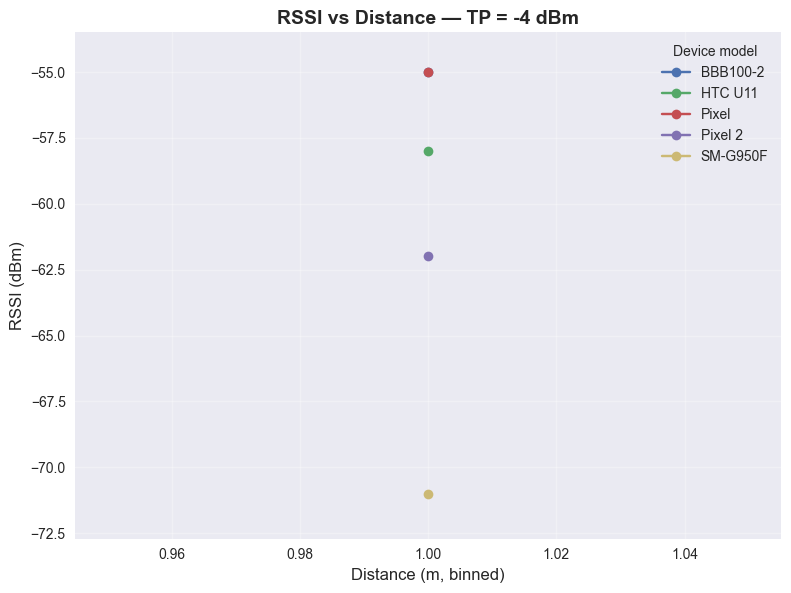

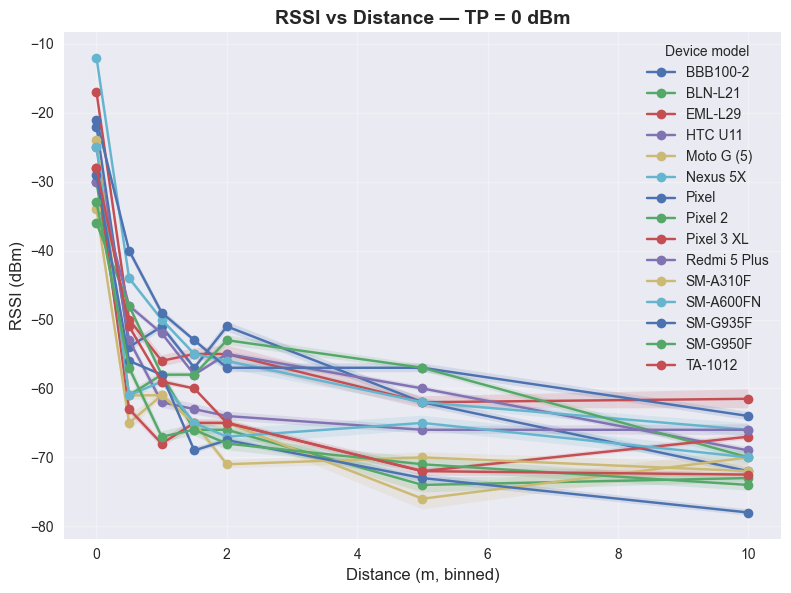

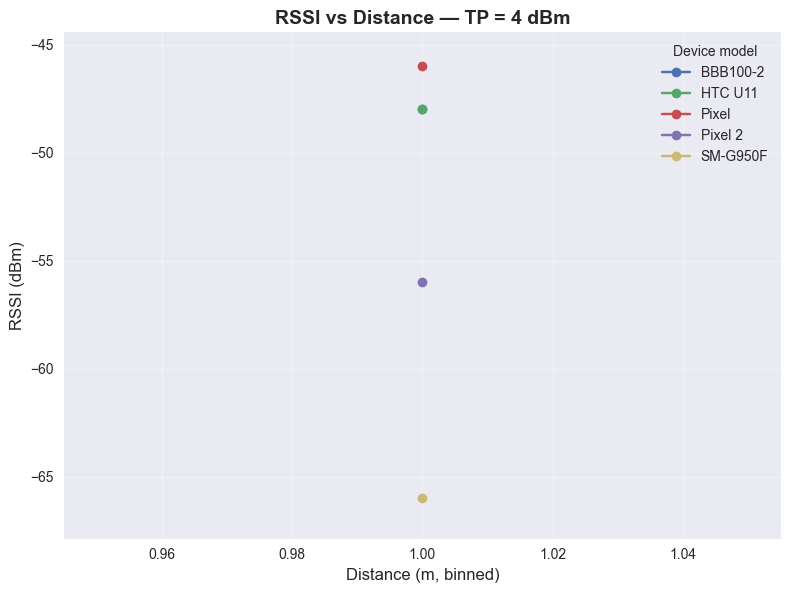

In [6]:
import json, re, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 可调参数 =====
DATA_DIR   = "recordings"      # 你的 JSON 文件夹
DIST_BIN   = 0.25        # 距离分箱宽度（米），可改为 0.5/1.0 等
AGG        = "median"    # 距离上聚合方法：'median' 或 'mean'
COMPARE_BY = "device"    # 'device' 对比手机型号；'beacon' 对比信标型号

# ===== 工具函数 =====
def coerce_tp(x):
    """把 transmissionPower 统一成整数 dBm"""
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return int(x)
    if isinstance(x, str):
        m = re.search(r'[-+]?\d+', x)
        return int(m.group()) if m else np.nan
    return np.nan

def get_field(d, dotted, default=None):
    """安全取嵌套字段：'a.b.c'"""
    cur = d
    for k in dotted.split('.'):
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

# ===== 读取与展开 =====
rows = []
for fp in Path(DATA_DIR).glob("*.json"):
    with open(fp, "r", encoding="utf-8") as f:
        d = json.load(f)

    # transmissionPower 兼容多种位置/格式
    tp = coerce_tp(
        get_field(d, "beaconInfo.transmissionPower",
        get_field(d, "transmissionPower"))
    )

    # 设备/信标型号
    dev_model    = get_field(d, "deviceInfo.model", get_field(d, "device.model"))
    beacon_model = get_field(d, "beaconInfo.model")

    # 距离（尽量转成 float）
    distance = get_field(d, "distance", get_field(d, "metrics.distance", np.nan))
    try:
        distance = float(distance)
    except Exception:
        distance = np.nan

    # RSSI 列表或单值
    rssis = get_field(d, "rssis")
    if rssis is None:
        rssi_val = get_field(d, "rssi")
        rssis = [rssi_val] if rssi_val is not None else []

    for r in rssis:
        try:
            r = float(r)
        except Exception:
            continue
        # 过滤不合理值（避免噪声影响趋势）
        if r > 5 or r < -120:
            continue
        rows.append({
            "tp_dbm": tp,
            "device_model": dev_model,
            "beacon_model": beacon_model,
            "distance": distance,
            "rssi": r,
            "src": fp.name
        })

df = pd.DataFrame(rows).dropna(subset=["tp_dbm", "distance", "rssi"])
if df.empty:
    raise SystemExit("没有解析到有效数据，请检查 DATA_DIR 或 JSON 结构。")

# 距离分箱，避免浮点“抖动”导致的分组错乱
df["dist_bin"] = (df["distance"] / DIST_BIN).round().astype(int) * DIST_BIN

# 选择对比维度
if COMPARE_BY == "device":
    compare_col = "device_model"
    legend_title = "Device model"
else:
    compare_col = "beacon_model"
    legend_title = "Beacon model"

# ===== 调试输出（强烈建议先看一眼）=====
print("已解析到的 transmissionPower（dBm）:", sorted(df["tp_dbm"].unique()))
print("\n每个功率 × 型号 的样本数：")
print(df.groupby(["tp_dbm", compare_col])["rssi"].size().unstack(fill_value=0))

# ===== 绘图 =====
for tp, g in df.groupby("tp_dbm"):
    plt.figure(figsize=(8, 6))
    for model, gg in g.groupby(compare_col):
        grp = gg.groupby("dist_bin")["rssi"]
        if AGG == "median":
            y = grp.median()
        else:
            y = grp.mean()

        x = y.index.values
        n = grp.count().reindex(y.index).fillna(1)
        std = grp.std().reindex(y.index).fillna(0.0)
        se = std / np.sqrt(n.clip(lower=1))
        ci = 1.96 * se

        # 排序后画线 + 置信区间
        order = np.argsort(x)
        x = x[order]
        y = y.values[order]
        ci = ci.values[order]

        plt.plot(x, y, marker="o", label=str(model))
        plt.fill_between(x, y - ci, y + ci, alpha=0.15)

    plt.title(f"RSSI vs Distance — TP = {tp} dBm")
    plt.xlabel(f"Distance (m, binned by {DIST_BIN})")
    plt.ylabel("RSSI (dBm)")
    plt.grid(True, alpha=0.3)
    plt.legend(title=legend_title, frameon=False)
    plt.tight_layout()
    plt.style.use("seaborn-v0_8")
    plt.title(f"RSSI vs Distance — TP = {tp} dBm", fontsize=14, weight="bold")
    plt.xlabel("Distance (m, binned)", fontsize=12)
    plt.ylabel("RSSI (dBm)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()


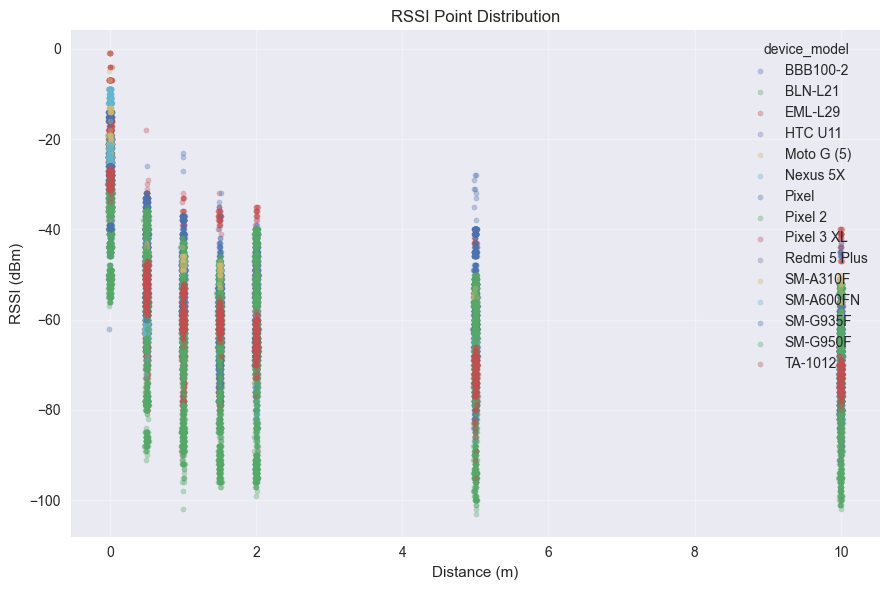

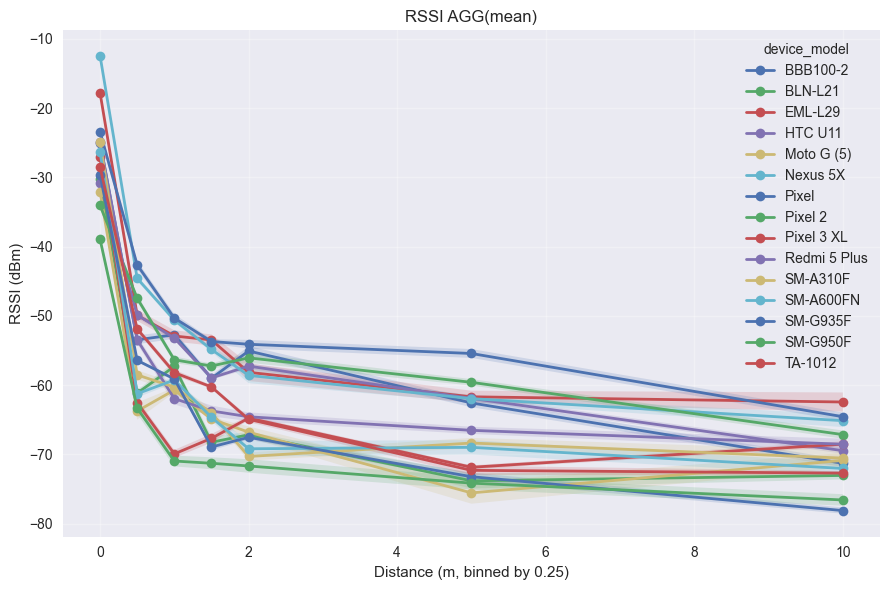

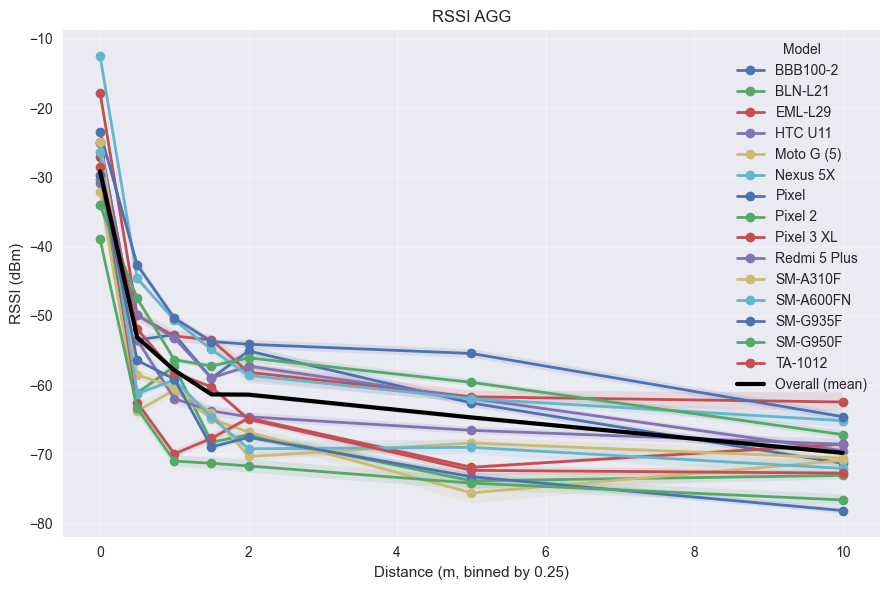

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 可调参数
DIST_BIN = 0.25      # 距离分箱宽度（米）
AGG = "mean"         # 'mean' 或 'median'
COMPARE_COL = "device_model"   # 也可换成 'beacon_model'

# --- 若 df 还没有分箱列，则创建 ---
if "dist_bin" not in locals() and "dist_bin" not in (df.columns if 'df' in locals() else []):
    df["dist_bin"] = (df["distance"] / DIST_BIN).round().astype(int) * DIST_BIN

# 只取 tp=0 的数据
df0 = df[df["tp_dbm"] == 0].copy()
if df0.empty:
    raise ValueError("在 df 中没有找到 tp=0 的数据，请检查 df['tp_dbm']。")

# ========== 图1：点分布图（散点） ==========
plt.figure(figsize=(9, 6))

# 轻微横向抖动，避免点完全重叠（仅用于视觉）
rng = np.random.default_rng(42)
x_jitter = rng.normal(0, DIST_BIN*0.04, size=len(df0))  # 抖动幅度 ~ 分箱宽度的 4%

for model, g in df0.groupby(COMPARE_COL):
    x = g["distance"].values + x_jitter[:len(g)]
    y = g["rssi"].values
    plt.scatter(x, y, s=14, alpha=0.35, label=str(model))

plt.title("RSSI Point Distribution")
plt.xlabel("Distance (m)")
plt.ylabel("RSSI (dBm)")
plt.grid(True, alpha=0.3)
plt.legend(title=COMPARE_COL, frameon=False, loc="best")
plt.tight_layout()
plt.show()

# ========== 图2：均值趋势图（带95%CI） ==========
plt.figure(figsize=(9, 6))

for model, g in df0.groupby(COMPARE_COL):
    grp = g.groupby("dist_bin")["rssi"]
    if AGG == "median":
        y = grp.median()
    else:
        y = grp.mean()

    n = grp.count().reindex(y.index).fillna(1)
    std = grp.std().reindex(y.index).fillna(0.0)
    se = std / np.sqrt(n.clip(lower=1))
    ci = 1.96 * se  # 近似95%置信区间

    x = y.index.values
    order = np.argsort(x)
    x = x[order]
    yv = y.values[order]
    civ = ci.values[order]

    plt.plot(x, yv, marker="o", linewidth=2, label=str(model))
    plt.fill_between(x, yv - civ, yv + civ, alpha=0.18)

plt.title(f"RSSI AGG({AGG})")
plt.xlabel(f"Distance (m, binned by {DIST_BIN})")
plt.ylabel("RSSI (dBm)")
plt.grid(True, alpha=0.3)
plt.legend(title=COMPARE_COL, frameon=False, loc="best")
plt.tight_layout()
plt.show()

# ========== 图2+总线：分型号趋势 + 总体趋势 ==========
plt.figure(figsize=(9, 6))

# --- 各型号曲线 ---
for model, g in df0.groupby(COMPARE_COL):
    grp = g.groupby("dist_bin")["rssi"]
    if AGG == "median":
        y = grp.median()
    else:
        y = grp.mean()

    n = grp.count().reindex(y.index).fillna(1)
    std = grp.std().reindex(y.index).fillna(0.0)
    se = std / np.sqrt(n.clip(lower=1))
    ci = 1.96 * se

    x = y.index.values
    order = np.argsort(x)
    x = x[order]
    yv = y.values[order]
    civ = ci.values[order]

    plt.plot(x, yv, marker="o", linewidth=2, label=str(model))
    plt.fill_between(x, yv - civ, yv + civ, alpha=0.12)

# --- 总体趋势线 (覆盖在图上) ---
g_all = df0.groupby("dist_bin")["rssi"]
if AGG == "median":
    y_all = g_all.median()
else:
    y_all = g_all.mean()

n_all = g_all.count().reindex(y_all.index).fillna(1)
std_all = g_all.std().reindex(y_all.index).fillna(0.0)
se_all = std_all / np.sqrt(n_all.clip(lower=1))
ci_all = 1.96 * se_all

x_all = y_all.index.values
order = np.argsort(x_all)
x_all = x_all[order]
yv_all = y_all.values[order]
civ_all = ci_all.values[order]

plt.plot(x_all, yv_all, color="black", linewidth=3,
         label=f"Overall ({AGG})", zorder=5)
plt.fill_between(x_all, yv_all - civ_all, yv_all + civ_all,
                 color="gray", alpha=0.25, zorder=4)

# --- 图形美化 ---
plt.title(f"RSSI AGG")
plt.xlabel(f"Distance (m, binned by {DIST_BIN})")
plt.ylabel("RSSI (dBm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Model", frameon=False, loc="best")
plt.tight_layout()
plt.show()




已解析到的 transmissionPower（dBm）: [-16, -8, -4, 0, 4]

每个功率 × 分组维度 的样本数：
device_beacon  BBB100-2 × Board  BLN-L21 × Board  EML-L29 × Board  \
tp_dbm                                                              
-16                         114                0                0   
-8                          106                0                0   
-4                          101                0                0   
 0                          927             1846             1898   
 4                          135                0                0   

device_beacon  HTC U11 × Board  Moto G (5) × Board  Nexus 5X × Board  \
tp_dbm                                                                 
-16                        240                   0                 0   
-8                         298                   0                 0   
-4                         324                   0                 0   
 0                        2482                 880              1379   
 4             

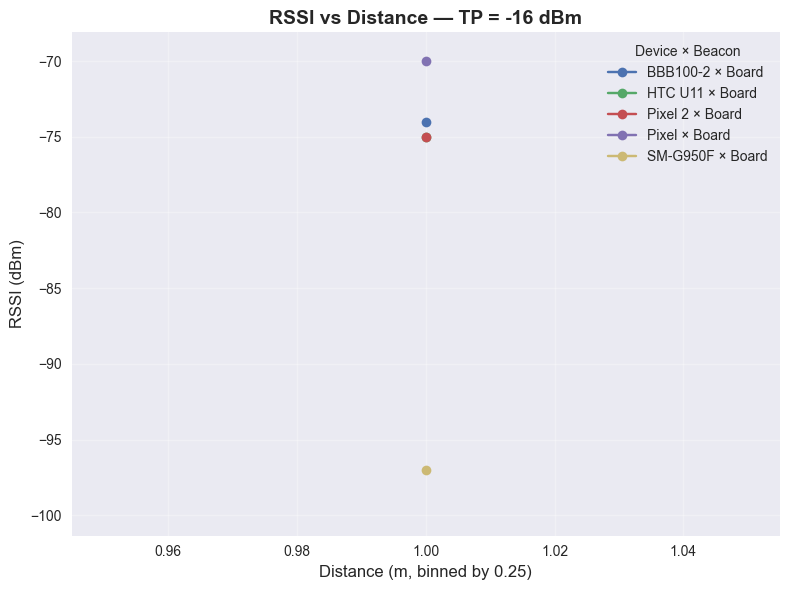

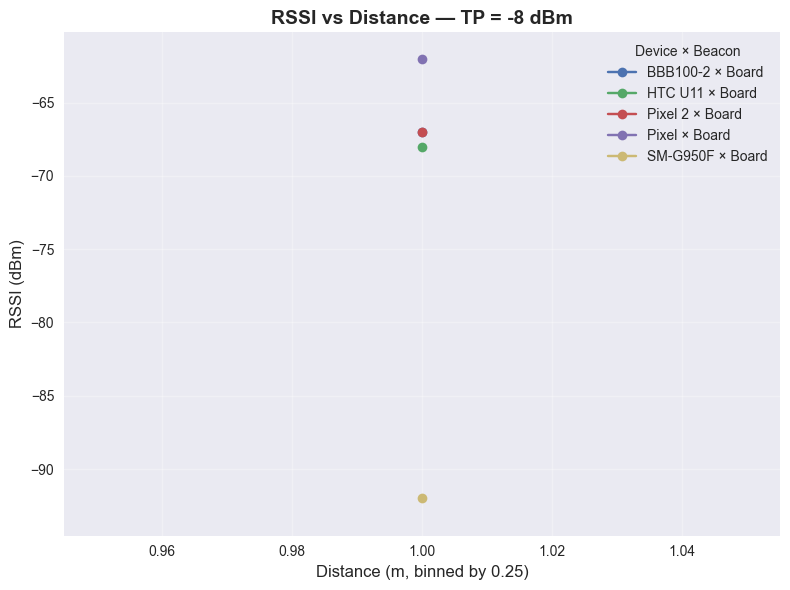

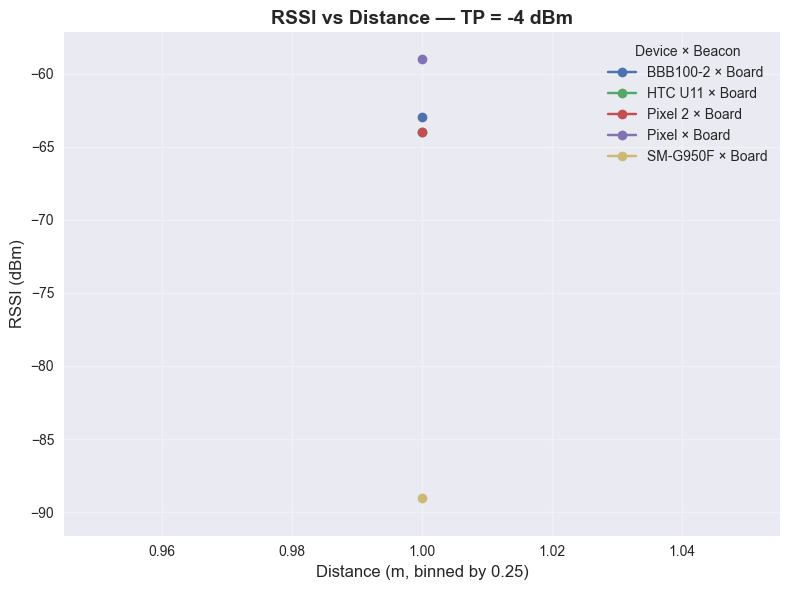

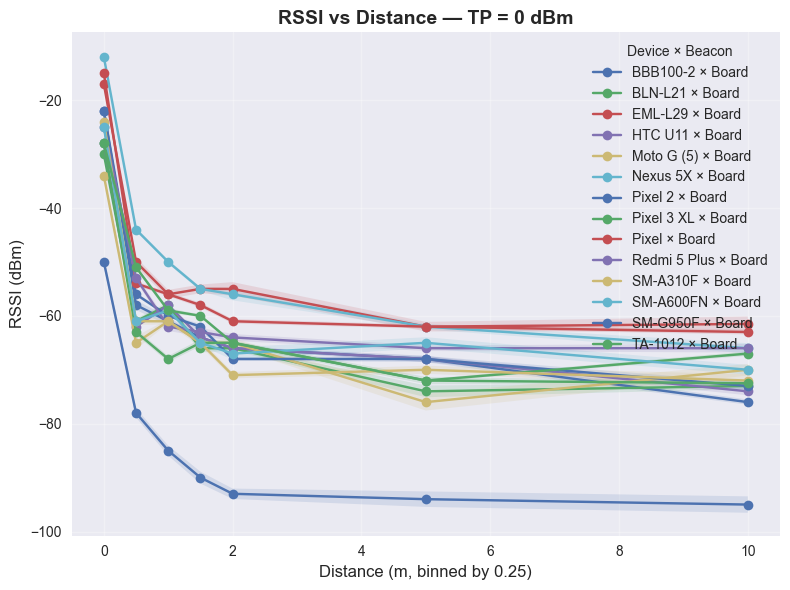

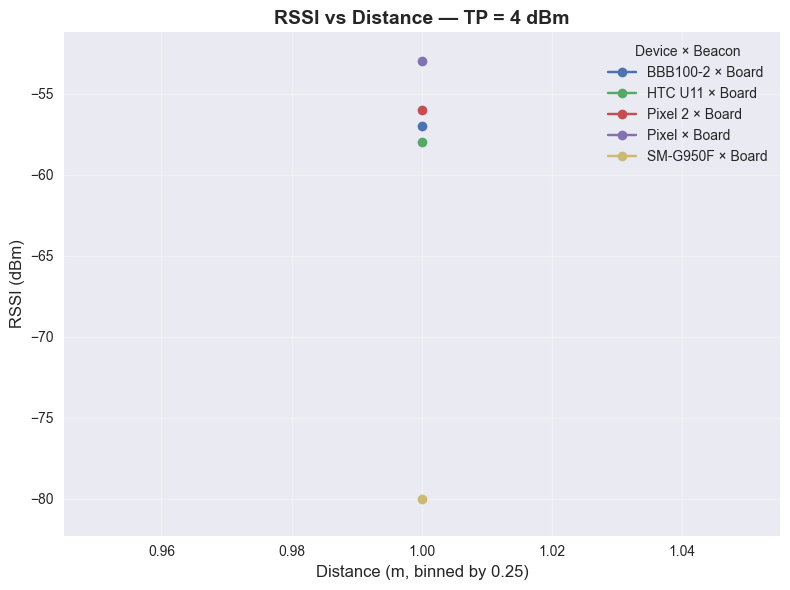

In [19]:
# -*- coding: utf-8 -*-
import json, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 可调参数 =====
DATA_DIR   = "recordings"   # 你的 JSON 文件夹
DIST_BIN   = 0.25           # 距离分箱宽度（米），可改为 0.5 / 1.0 等
AGG        = "median"       # 距离上聚合：'median' 或 'mean'
COMPARE_BY = "both"         # 'device'（手机）、'beacon'（信标）、'both'（组合）
FILTER_BEACON_MODEL = 'Board'  # 例如 "Maxi"（仅绘制该型号）；为 None 则不过滤

# ===== 工具函数 =====
def coerce_tp(x):
    """把 transmissionPower 统一成整数 dBm"""
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return int(x)
    if isinstance(x, str):
        m = re.search(r'[-+]?\d+', x)
        return int(m.group()) if m else np.nan
    return np.nan

def get_field(d, dotted, default=None):
    """安全取嵌套字段：'a.b.c'"""
    cur = d
    for k in dotted.split('.'):
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

# ===== 读取与展开 =====
rows = []
for fp in Path(DATA_DIR).glob("*.json"):
    try:
        with open(fp, "r", encoding="utf-8") as f:
            d = json.load(f)
    except Exception:
        continue

    # transmissionPower 兼容多种位置/格式
    tp = coerce_tp(
        get_field(d, "beaconInfo.transmissionPower",
        get_field(d, "transmissionPower"))
    )

    # 设备/信标信息
    dev_model    = get_field(d, "deviceInfo.model", get_field(d, "device.model"))
    beacon_model = get_field(d, "beaconInfo.model", get_field(d, "model"))
    beacon_name  = get_field(d, "beaconInfo.name")
    manufacturer = get_field(d, "beaconInfo.manufacturer")
    adv_freq     = get_field(d, "beaconInfo.advertisingFrequency")

    # 距离（尽量转成 float）
    distance = get_field(d, "distance", get_field(d, "metrics.distance", np.nan))
    try:
        distance = float(distance)
    except Exception:
        distance = np.nan

    # RSSI 列表或单值
    rssis = get_field(d, "rssis")
    if rssis is None:
        rssi_val = get_field(d, "rssi")
        rssis = [rssi_val] if rssi_val is not None else []

    for r in rssis:
        try:
            r = float(r)
        except Exception:
            continue
        # 过滤不合理值（避免噪声影响趋势）
        if r > 5 or r < -120:
            continue
        rows.append({
            "tp_dbm": tp,
            "device_model": dev_model,
            "beacon_model": beacon_model,
            "beacon_name": beacon_name,
            "manufacturer": manufacturer,
            "adv_freq": adv_freq,
            "distance": distance,
            "rssi": r,
            "src": fp.name
        })

df = pd.DataFrame(rows).dropna(subset=["tp_dbm", "distance", "rssi"])
if df.empty:
    raise SystemExit("没有解析到有效数据，请检查 DATA_DIR 或 JSON 结构。")

# ===== 可选：过滤某个信标型号（如只看 Maxi）=====
if FILTER_BEACON_MODEL is not None:
    df = df[df["beacon_model"].astype(str) == str(FILTER_BEACON_MODEL)]
    if df.empty:
        raise SystemExit(f"过滤后无数据（beacon_model == {FILTER_BEACON_MODEL}）。")

# ===== 距离分箱，避免浮点“抖动”导致的分组错乱 =====
df["dist_bin"] = (df["distance"] / DIST_BIN).round().astype(int) * DIST_BIN

# ===== 组合维度（用于 COMPARE_BY='both'）=====
df["device_beacon"] = df["device_model"].astype(str) + " × " + df["beacon_model"].astype(str)

# ===== 选择对比维度 =====
if COMPARE_BY == "device":
    compare_col = "device_model"
    legend_title = "Device model"
elif COMPARE_BY == "beacon":
    compare_col = "beacon_model"
    legend_title = "Beacon model"
elif COMPARE_BY == "both":
    compare_col = "device_beacon"
    legend_title = "Device × Beacon"
else:
    raise SystemExit("COMPARE_BY 只支持 'device' / 'beacon' / 'both'")

# ===== 调试输出 =====
print("已解析到的 transmissionPower（dBm）:", sorted(df["tp_dbm"].unique()))
print("\n每个功率 × 分组维度 的样本数：")
print(df.groupby(["tp_dbm", compare_col])["rssi"].size().unstack(fill_value=0))

# ===== 绘图（按照不同 tp_dbm 画多张图）=====
for tp, g in df.groupby("tp_dbm"):
    plt.figure(figsize=(8, 6))

    for label, gg in g.groupby(compare_col):
        grp = gg.groupby("dist_bin")["rssi"]
        y = grp.median() if AGG == "median" else grp.mean()

        x = y.index.values
        n = grp.count().reindex(y.index).fillna(1)
        std = grp.std().reindex(y.index).fillna(0.0)
        se = std / np.sqrt(n.clip(lower=1))
        ci = 1.96 * se  # 约 95% 置信区间

        # 排序后画线 + 置信区间
        order = np.argsort(x)
        x = x[order]
        y = y.values[order]
        ci = ci.values[order]

        plt.plot(x, y, marker="o", label=str(label))
        plt.fill_between(x, y - ci, y + ci, alpha=0.15)

    plt.title(f"RSSI vs Distance — TP = {tp} dBm", fontsize=14, weight="bold")
    plt.xlabel(f"Distance (m, binned by {DIST_BIN})", fontsize=12)
    plt.ylabel("RSSI (dBm)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title=legend_title, frameon=False)
    plt.tight_layout()
    plt.show()
